# Bayesian Bandits: An Application of Thompson Sampling

#### EE 290S/CS 194: Machine Learning for Sequential Decision Making Under Uncertainty (Fall 2018)

#### Authors: Julian Chan, Daniel Ho, Bernie Wang

This notebook implements the Thompson Sampling algorithm described in [Analysis of Thompson Sampling for the Multi-Armed Bandit Problem](http://proceedings.mlr.press/v23/agrawal12/agrawal12.pdf) by Shipra Agrawal and Navin Goyal and applies it to the Bayesian Bandit problem.

** Note that "bandit" and "arm" are used interchangeably in this notebook (and in the Online Learning literature in general). **

## Table of Contents
[Section 1: Thompson Sampling for Bernoulli Bandits](#section1)

[Section 2: Thompson Sampling for General Stochastic Bandits](#section2)

## Section 1: Thompson Sampling for Bernoulli Bandits <a name="section1"></a>

We will first examine the Bernoulli Bandit case where:
* Rewards $r_t \in \{0, 1\}$ drawn from a Bernoulli distribution
* For arm $i$, the probability of success ($r_{t,i} = 1$) is its mean, $\mu_i$

We maintain a Bayesian prior on the arm means $\mu_i$. For Bernoulli rewards (either 0 or 1), it turns out that a Beta distribution is a convenient choice of priors. This is because if the prior is a Beta($\alpha$, $\beta$) distribution, then updating the posterior distributions become much simpler. After observing a Bernoulli trial, the posterior distribution is:
* Beta($\alpha+1$, $\beta$) if the trial succeeded (reward = 1)
* Beta($\alpha$, $\beta+1$) if the trial failed (reward = 0)

The Thompson Sampling algorithm initializes a uniform prior on all arms, meaning that arm $i$ has a prior Beta(1,1) on $\mu_i$ because Beta(1,1) is a uniform distribution on (0,1).

Define:
* $S_i(t)$ = number of successes (reward = 1) for arm $i$ up to time $t$
* $F_i(t)$ = number of failures (reward = 0) for arm $i$ up to time $t$

The algorithm will then update the distribution on $\mu_i$ as Beta($S_i(t)+1$, $F_i(t)+1$), sample from these posterior distributions, and play an arm according to the probability of its mean being the largest.

---
#### Algorithm 1: Thompson Sampling for Bernoulli Bandits
For each arm $i=1,...,N$, set $S_i(1)=0$, $F_i(1)=0$

For each  $t=1,2,...$ do

* For each arm $i=1,...,N$, sample $\theta_i(t)$ from the Beta($S_i(t)+1$, $F_i(t)+1$) distribution
* Play arm $i(t) := argmax_i$ $\theta_i(t)$ and observe reward $r_t$
* If $r_t=1$, then $S_i(t) = S_i(t)+1$, else $F_i(t) = F_i(t)+1$
---

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
class MultiArmedBandit:
    def __init__(self, num_bandits):
        """num_bandits must be at least 2"""
        
        assert num_bandits >= 2, "Number of bandits must be at least 2"
        
        # Initialize the means for each of the bandits randomly
        self.bandits = np.random.random_sample(num_bandits)
        self.num_bandits = len(self.bandits)
        # Keep track of the largest probability to use in regret calculation as "best bandit"
        self.max_prob = np.max(self.bandits)
    
    # Should define this method when extending the class
    def chooseBandit(self, bandit_num):
        """
        Chooses the indicated bandit and returns True if we get a reward, False otherwise.
        """
        pass
    
    def computeRegret(self, bandit_num):
        """
        Computes the regret accrued by the indicated bandit. By definition, this is how much reward we lost by
        choosing the indicated bandit instead of the best one (indicated by the bandit with the largest mean).
        """
        # Index out of range
        assert bandit_num >= 0 and bandit_num < self.num_bandits, \
            "Index Out of Range: {}. There are {} bandits.".format(bandit_num, self.num_bandits)
        
        # Difference in expected reward for choosing a suboptimal bandit
        return self.max_prob - self.bandits[bandit_num]

    def __repr__(self):
        """Print out the means for each bandit arm."""
        return "Bandits: " + self.bandits.__str__()
    
    def __str__(self):
        return self.__repr__()
        
    
class BernoulliBandit(MultiArmedBandit):
    def __init__(self, num_bandits):
        super(BernoulliBandit, self).__init__(num_bandits)
        
    def chooseBandit(self, bandit_num):
        """
        Chooses the indicated bandit and returns True if we get a reward, False otherwise.
        """
        # Index out of range
        assert bandit_num >= 0 and bandit_num < self.num_bandits, \
            "Index Out of Range: {}. There are {} bandits.".format(bandit_num, self.num_bandits)
            
        # Sample from Bernoulli distribution with probability of success equal to the bandit mean
        return np.random.binomial(1, self.bandits[bandit_num]) == 1

    
def draw_bandit_distribution(stats):
    """
    Samples the probability of each bandit yielding a reward given the number of successes and failures so far.
    This is computed using the Beta distribution.
    
    stats = [{'num_wins': __, 'num_losses': __}, ...]
    len(stats) should be equal to the number of bandits
    """
    reward_probs = np.zeros(len(stats))
    
    for bandit_num in range(len(stats)):
        num_wins, num_losses = stats[bandit_num]['num_wins'], stats[bandit_num]['num_losses']
        # The alpha parameter is num_wins+1 and the beta parameter is num_losses+1
        reward_probs[bandit_num] = np.random.beta(num_wins+1, num_losses+1)
    
    return reward_probs

In [58]:
# CHANGE THIS TO EXPERIMENT
num_bandits = 5
num_iterations = 1000

In [63]:
bandits = BernoulliBandit(num_bandits)

# Bookkeeping
bandit_stats = np.zeros(num_bandits, dtype=[('num_wins', np.int), ('num_losses', np.int)])
overall_stats = np.zeros(num_iterations, dtype=[('bandit', np.int), ('num_wins', np.int), \
                                                ('num_losses', np.int), ('regret', np.float64)])

In [64]:
for iteration in range(num_iterations):
    if iteration != 0:
        # Deep copy statistics from the previous iteration
        overall_stats[iteration] = overall_stats[iteration - 1].copy()
        
        # Draw from the existing Beta distribution for each bandit
        thetas = draw_bandit_distribution(bandit_stats)
        
        # Find the bandit with the highest probability to yield a reward and choose it
        selected_bandit = np.argmax(thetas)
        # Update the overall_stats that the bandit chosen for this round is selected_bandit
        overall_stats[iteration]['bandit'] = selected_bandit
        
        if bandits.chooseBandit(selected_bandit):
            # The selected bandit yielded a reward! (Success)
            bandit_stats[selected_bandit]['num_wins'] += 1
            overall_stats[iteration]['num_wins'] += 1
        else:
            # The selected bandit did not yield a reward. (Failed)
            bandit_stats[selected_bandit]['num_losses'] += 1
            overall_stats[iteration]['num_losses'] += 1
        
        # Update the overall_stats with any regret accrued in this iteration
        overall_stats[iteration]['regret'] += bandits.computeRegret(selected_bandit)

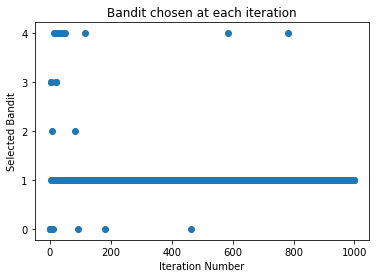

In [65]:
# Plot the chosen bandit at each iteration
plt.scatter(range(num_iterations), overall_stats['bandit'])
plt.yticks(range(num_bandits))
plt.xlabel("Iteration Number")
plt.ylabel("Selected Bandit")
plt.title("Bandit chosen at each iteration")

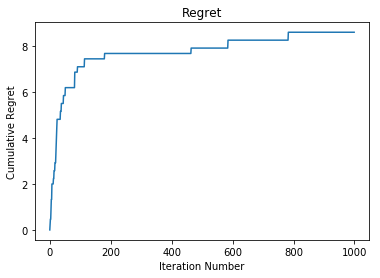

In [66]:
# Plot the accumulated regret through the experiment
plt.plot(range(num_iterations), overall_stats['regret'])
plt.xlabel("Iteration Number")
plt.ylabel("Cumulative Regret")
plt.title("Regret")

## Section 2: Thompson Sampling for General Stochastic Bandits <a name="section2"></a>

Now we'll extend the Thompson Sampling algorithm to general stochastic bandit case, where:
* Rewards $r_i \in [0,1]$ drawn from an arbitrary unknown distribution
* Each arm $i$ has mean $\mu_i$

However, we will adapt the algorithm in a way that allows us to reuse the analysis of the Bernoulli Bandit. We will again make use of the Beta distribution as a convenient prior on the bandit arms.

The idea is that after observing the reward $\tilde{r}_t \in [0,1]$ at time $t$, we will perform a Bernoulli trial with probability of success $p = \tilde{r}_t$. Let the outcome of this Bernoulli trial be $r_t \in \{0,1\}$. Again, let $S_i(t)$ and $F_i(t)$ be the number of successes and failures up to time $t$, respectively, as before. 

Notice that the probability of observing a success in the Bernoulli trial after playing an arm $i$ in the new algorithm is the mean of that arm $\mu_i$. If we let $f_i$ denote the pdf of the unknown reward distribution for arm $i$. So, when playing arm $i$:
$$\Pr(r_t=1) = \int_{0}^{1} \tilde{r}f_i(\tilde{r})d\tilde{r} = \mu_i$$

---
#### Algorithm 2: Thompson Sampling for General Stochastic Bandits
For each arm $i=1,...,N$, set $S_i(1)=0$, $F_i(1)=0$

For each  $t=1,2,...$ do

* For each arm $i=1,...,N$, sample $\theta_i(t)$ from the Beta($S_i(t)+1$, $F_i(t)+1$) distribution
* Play arm $i(t) := argmax_i$ $\theta_i(t)$ and observe reward $\tilde{r}_t$
* Perform a Bernoulli trial with success probability $\tilde{r}_t$ and observe output $r_t$
* If $r_t=1$, then $S_i(t) = S_i(t)+1$, else $F_i(t) = F_i(t)+1$
---

In [67]:
class UniformBandit(MultiArmedBandit):
    def __init__(self, num_bandits):
        super(UniformBandit, self).__init__(num_bandits)
        
    def chooseBandit(self, bandit_num):
        """
        Chooses the indicated bandit and returns True if we get a reward, False otherwise.
        """
        # Index out of range
        assert bandit_num >= 0 and bandit_num < self.num_bandits, \
            "Index Out of Range: {}. There are {} bandits.".format(bandit_num, self.num_bandits)
            
        # Sample from uniform distribution with probability of success equal to the bandit mean
        return np.random.uniform(0, 1) <= self.bandits[bandit_num] 

In [68]:
# CHANGE THIS TO EXPERIMENT
num_bandits = 5
num_iterations = 1000

In [76]:
bandits = UniformBandit(num_bandits)

# Bookkeeping
bandit_stats = np.zeros(num_bandits, dtype=[('num_wins', np.int), ('num_losses', np.int)])
overall_stats = np.zeros(num_iterations, dtype=[('bandit', np.int), ('num_wins', np.int), \
                                                ('num_losses', np.int), ('regret', np.float64)])

In [77]:
for iteration in range(num_iterations):
    if iteration != 0:
        # Deep copy statistics from the previous iteration
        overall_stats[iteration] = overall_stats[iteration - 1].copy()
        
        # Draw from the existing Beta distribution for each bandit
        thetas = draw_bandit_distribution(bandit_stats)
        
        # Find the bandit with the highest probability to yield a reward and choose it
        selected_bandit = np.argmax(thetas)
        # Update the overall_stats that the bandit chosen for this round is selected_bandit
        overall_stats[iteration]['bandit'] = selected_bandit
        
        if bandits.chooseBandit(selected_bandit):
            # The selected bandit yielded a reward! (Success)
            bandit_stats[selected_bandit]['num_wins'] += 1
            overall_stats[iteration]['num_wins'] += 1
        else:
            # The selected bandit did not yield a reward. (Failed)
            bandit_stats[selected_bandit]['num_losses'] += 1
            overall_stats[iteration]['num_losses'] += 1
        
        # Update the overall_stats with any regret accrued in this iteration
        overall_stats[iteration]['regret'] += bandits.computeRegret(selected_bandit)

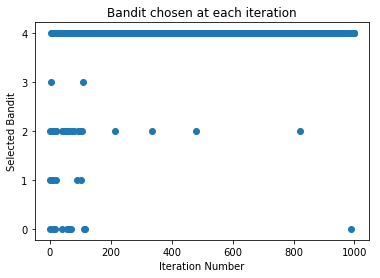

In [78]:
# Plot the chosen bandit at each iteration
plt.scatter(range(num_iterations), overall_stats['bandit'])
plt.yticks(range(num_bandits))
plt.xlabel("Iteration Number")
plt.ylabel("Selected Bandit")
plt.title("Bandit chosen at each iteration")

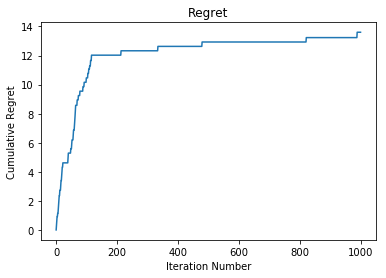

In [79]:
# Plot the accumulated regret through the experiment
plt.plot(range(num_iterations), overall_stats['regret'])
plt.xlabel("Iteration Number")
plt.ylabel("Cumulative Regret")
plt.title("Regret")